# Note:
The data for this project has not been provided in the GitHub repository. However, the Van Allen Probes data is available at the Coordinated Data Analysis Web (CDAWeb) https://cdaweb.gsfc.nasa.gov/ and the OMNI data is available at https://omniweb.gsfc.nasa.gov/.

# Important Physics Point:
This Data Cleaning Algorthm is designed to process this specific mission data. Each step taken in the following code has a scientific basis for being included or excluded. For example, the instruments on the Van Allen Space Probe (Radiation Belt Space Probe RBSP) often lose accuracy when travelling through low L shells, i.e. closer to the Earth due to the increase in the probe's velocity hence their removal.

In [7]:
# Importing Libraries 
import numpy as np
impoprt pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from scipy.io import readsav
import scipy
import os 
import glob
from datetime import datetime
from datetime import timedelta
import h5py
import statistics
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from scipy.stats import lognorm

In [8]:
# Set the base directory (modify if needed)
base_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data"

# Original Load Firing Times Function
def load_firing_times(probe_name):
    firing_times_files = {
        "RBSP-A": os.path.join(base_directory, "rbsp-a_thruster_firing_times.txt"),
        "RBSP-B": os.path.join(base_directory, "rbsp-b_thruster_firing_times.txt"),
    }
    time_format = "%Y-%m-%dT%H:%M:%S.%f"
    file_path = firing_times_files[probe_name]
    firing_times = pd.read_csv(file_path, delimiter=',')

    def columns(data_file, Variable):
        if data_file == "RBSP-A":
            Start_Time = "Start Time"
            End_Time = " End Time"
        if data_file == "RBSP-B":
            Start_Time = "#Start Time"
            End_Time = " End Time"

        if Variable == "Start_Time":
            return Start_Time
        if Variable == "End_Time":
            return End_Time

    # The data has an extra 3 zeros than required so we only convert the necessary part to prevent errors.
    start_column = columns(probe_name, "Start_Time")
    start_times = [datetime.strptime(t.strip()[0:26], time_format) for t in firing_times[start_column]]

    end_column = columns(probe_name, "End_Time")
    end_times = [datetime.strptime(t.strip()[0:26], time_format) for t in firing_times[end_column]]
    end_times = [t + timedelta(hours=12) for t in end_times]

    return list(zip(start_times, end_times))

def load_RBSP_variable(satelite, coordinate, variable, key=None):
    # Creating a list of all files
    file_loc = glob.glob(os.path.join(base_directory, satelite, f"*{coordinate}*"))
    overall_variable = []
    overall_time = []
    overall_lshell = []
    overall_b_fft = []
    overall_e_fft = []

    # Loading all files and adding data to lists
    for file_path in file_loc:
        original_data = readsav(file_path)
        variable_original = original_data[variable]
        time_original = original_data['t_dat']  # Needed for thruster removal
        l_shell_original = original_data['l_dat']  # Needed for x < L = 4 removal
        b_fft_original = original_data['b_fft']
        e_fft_original = original_data['e_fft']

        overall_b_fft.append(b_fft_original)
        overall_e_fft.append(e_fft_original)
        overall_variable.append(variable_original)
        overall_time.append(time_original)
        overall_lshell.append(l_shell_original)

    if variable == "f_fft":
        return original_data['f_fft']

    # Concatenating lists
    overall_variable = np.concatenate(overall_variable)
    overall_time = np.concatenate(overall_time)
    overall_lshell = np.concatenate(overall_lshell)
    overall_b_fft = np.concatenate(overall_b_fft)
    overall_e_fft = np.concatenate(overall_e_fft)

    # Removing Nan Values
    if key == "e_fft":
        nan_mask = ~np.isnan(overall_e_fft).any(axis=1)
        overall_variable = overall_variable[nan_mask]
        overall_time = overall_time[nan_mask]
        overall_lshell = overall_lshell[nan_mask]
        overall_b_fft = overall_b_fft[nan_mask]
    else:
        nan_mask = ~np.isnan(overall_b_fft).any(axis=1)
        overall_variable = overall_variable[nan_mask]
        overall_time = overall_time[nan_mask]
        overall_lshell = overall_lshell[nan_mask]
        overall_b_fft = overall_b_fft[nan_mask]

    # Converting time to datetime (t_dat is a timestamp, not a string)
    overall_time = np.array([datetime.fromtimestamp(t) for t in overall_time])

    # ------------------------------------------------------------------
    # Record initial data count BEFORE any filtering
    initial_count = len(overall_time)
    print(f"Initial Data Points: {initial_count}")

    # STEP 1: Removing Thruster Affected Data
    thruster_firing_times = load_firing_times(satelite)
    thruster_firing_mask = np.ones(len(overall_time), dtype=bool)
    for start, end in thruster_firing_times:
        # Create a mask that is False during the thruster firing period
        thruster_firing_mask &= ~((overall_time >= start) & (overall_time <= end))
    count_after_thruster = np.sum(thruster_firing_mask)
    thruster_removed_count = initial_count - count_after_thruster
    print(f"Removed by Thruster: {thruster_removed_count} ({(thruster_removed_count / initial_count) * 100:.2f}%)")

    # Apply thruster filtering
    overall_variable = overall_variable[thruster_firing_mask]
    overall_time = overall_time[thruster_firing_mask]
    overall_lshell = overall_lshell[thruster_firing_mask]
    overall_b_fft = overall_b_fft[thruster_firing_mask]

    # STEP 2: Removing Low L-Shell Data (keep only those with l_shell > 4)
    count_before_lshell = len(overall_time)
    low_lshell_mask = overall_lshell > 4  # True for l_shell values greater than 4
    count_after_lshell = np.sum(low_lshell_mask)
    lshell_removed_count = count_before_lshell - count_after_lshell
    print(f"Removed by L-Shell: {lshell_removed_count} ({(lshell_removed_count / initial_count) * 100:.2f}%)")

    # Apply L-shell filtering
    overall_variable = overall_variable[low_lshell_mask]
    overall_time = overall_time[low_lshell_mask]
    overall_lshell = overall_lshell[low_lshell_mask]
    overall_b_fft = overall_b_fft[low_lshell_mask]

    # If key=="original", return the data now
    if key == "original":
        return overall_variable

    # STEP 3: Removing Values Outside the IQR Range
    count_before_iqr = len(overall_time)
    # Calculate the sum along each row of overall_b_fft
    summed_b_fft = np.array([row.sum() for row in overall_b_fft])

    # Group indices based on overall_lshell bins: [4,5), [5,6), [6,7)
    index_list_4 = np.where((overall_lshell >= 4) & (overall_lshell < 5))[0]
    index_list_5 = np.where((overall_lshell >= 5) & (overall_lshell < 6))[0]
    index_list_6 = np.where((overall_lshell >= 6) & (overall_lshell < 7))[0]

    # Create an overall IQR mask (initialize all as True)
    iqr_mask = np.ones(len(summed_b_fft), dtype=bool)

    # Process each group separately
    for indices in [index_list_4, index_list_5, index_list_6]:
        if len(indices) > 0:
            group_values = summed_b_fft[indices]
            LQ, UQ = np.percentile(group_values, [25, 75])
            IQR = UQ - LQ
            # Keep values within [LQ - 1.5*IQR, UQ + 1.5*IQR]
            group_mask = (group_values >= LQ - 1.5 * IQR) & (group_values <= UQ + 1.5 * IQR)
            iqr_mask[indices] = group_mask

    count_after_iqr = np.sum(iqr_mask)
    iqr_removed_count = count_before_iqr - count_after_iqr
    print(f"Removed by IQR: {iqr_removed_count} ({(iqr_removed_count / initial_count) * 100:.2f}%)")

    # Apply IQR filtering
    overall_variable = overall_variable[iqr_mask]
    overall_time = overall_time[iqr_mask]
    overall_lshell = overall_lshell[iqr_mask]
    overall_b_fft = overall_b_fft[iqr_mask]

    # Final data count after all filtering
    final_count = len(overall_time)
    print(f"Final Data Points: {final_count} ({(final_count / initial_count) * 100:.2f}% remaining)")

    # Return the requested variable
    if variable == "t_dat":
        return overall_time
    if variable == "l_dat":
        return overall_lshell
    else:
        return overall_variable

In [9]:
base_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data"
radial_psd = load_RBSP_variable("RBSP-A", "00", "b_fft")
radial_time = load_RBSP_variable("RBSP-A", "00", "t_dat")
radial_lshell = load_RBSP_variable("RBSP-A", "00", "l_dat")
VAP_freq = load_RBSP_variable("RBSP-A", "00", "f_fft")

Initial Data Points: 672722
Removed by Thruster: 22853 (3.40%)
Removed by L-Shell: 122173 (18.16%)
Removed by IQR: 74043 (11.01%)
Final Data Points: 453653 (67.44% remaining)
Initial Data Points: 672722
Removed by Thruster: 22853 (3.40%)
Removed by L-Shell: 122173 (18.16%)
Removed by IQR: 74043 (11.01%)
Final Data Points: 453653 (67.44% remaining)
Initial Data Points: 672722
Removed by Thruster: 22853 (3.40%)
Removed by L-Shell: 122173 (18.16%)
Removed by IQR: 74043 (11.01%)
Final Data Points: 453653 (67.44% remaining)


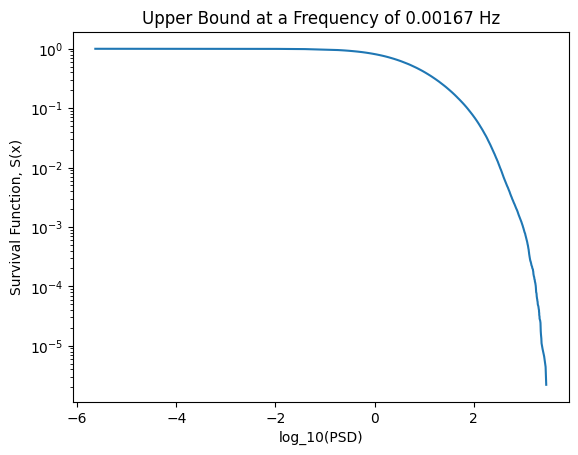

In [39]:
data = np.log10(radial_psd[:,2])
x = np.sort(data)
y = np.arange(len(x)) / float(len(x)) 

plt.figure()
plt.plot(x,(1-y))
plt.yscale("log")
plt.xlabel("log_10(PSD)")
plt.ylabel("Survival Function, S(x)")
plt.title("Upper Bound at a Frequency of "f'{VAP_freq[2]:.5f} Hz')
plt.show()